In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import json
import requests
import plotly.express as px
import matplotlib.pyplot as plt
from termcolor import colored                     # coloration du texte
from scipy import stats                           # lois de probabilité (valeurs extrêmes)
from scipy.stats import gumbel_r, genextreme      # valeurs extrêmes
from pyextremes import EVA                        # valeurs extrêmes  
from tabulate import tabulate                     # impression du texte dans un format tabulé
plt.rcParams['text.usetex'] = True                # paramètres latex


plt.rcParams['text.latex.preamble'] = '\\usepackage{libertine}'
plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Times New Roman",
    "font.family": "Linux Libertine",
    "font.size": 12
})
# from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)


from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#plt.style.use('default')

import arviz as az
import pymc as pm
import pymc_experimental.distributions as pmx
import pytensor.tensor as pt
from arviz.plots import plot_utils as azpu
from scipy.optimize import fsolve
import scipy.optimize as optimize

################################
## Auteur : Christoophe Ancey ##
## Date : novembre 2024       ##
################################

# Importation des données

In [2]:
data = pd.read_csv('order_125956_data.txt',skiprows=3,sep=r'\s+',names=['nom','date','precip'],date_format='%Y%m%d',parse_dates= ['date'])

In [3]:
data 

,nom,date,precip
0,LSN,1900-01-01,1.9
1,LSN,1900-01-02,6.8
2,LSN,1900-01-03,33.8
3,LSN,1900-01-04,10.2
4,LSN,1900-01-05,6.1
...,...,...,...
45590,LSN,2024-10-27,0.0
45591,LSN,2024-10-28,0.0
45592,LSN,2024-10-29,0.0
45593,LSN,2024-10-30,0.0


## Tracé de la série temporelle (précipitations sur Lausanne)

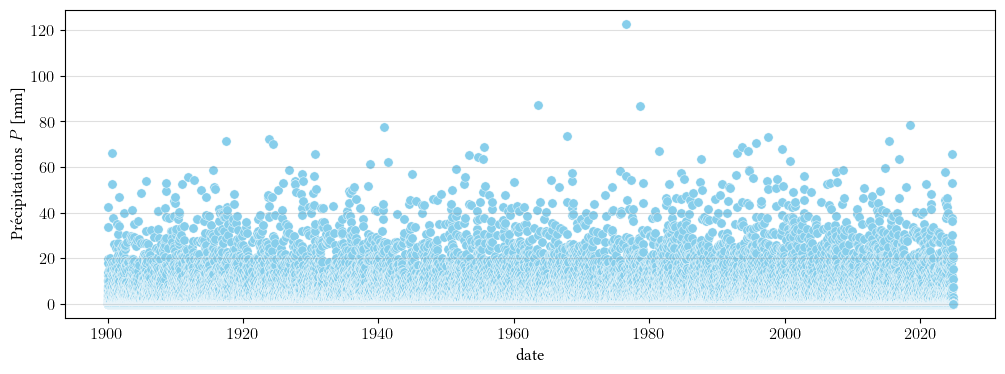

In [4]:
 # distribution temporelle des distributions
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(data['date'], data["precip"] ,  marker = "o",edgecolors='white',linewidths=0.3, s=45, color='skyblue', alpha = 1)
ax.set_ylabel(r'Précipitations $P$  [mm] ')
ax.set_xlabel(r'date')
plt.grid(axis="y", color = 'gray', alpha = 0.25)
 

# Test de stationnarité

## Depuis 1900

In [5]:
# on sélectionne les pluies suffisamment significatives P > 1 mm
pluies = data[data['precip']>1]
# on définit la date d'occurrence
dates = np.array(pluies.date)

In [6]:
# on calcule l'intervalle de temps entre deux occurrences
# comme dans python, l'unité de temps est la nanoseconde (ns), on divise par le nombre de nanosecondes en une journée pour 
# exprimer les intervalles de temps en jours
délai = np.diff(dates)/ np.timedelta64(1, 'D')
temps_cumulé = np.cumsum(délai)
durée_totale = temps_cumulé[-1]-temps_cumulé[0]
# On définit le nombre d'événements
nb_evt = len(pluies)
# on définit la durée totale de la série temporelle
# taux annuel des précipitations
print(f"En moyenne, il y a {nb_evt/durée_totale*365.25:0.1f} précipitations par an à Lausanne.")

En moyenne, il y a 118.8 précipitations par an à Lausanne.


Text(0, 0.5, 'rang')

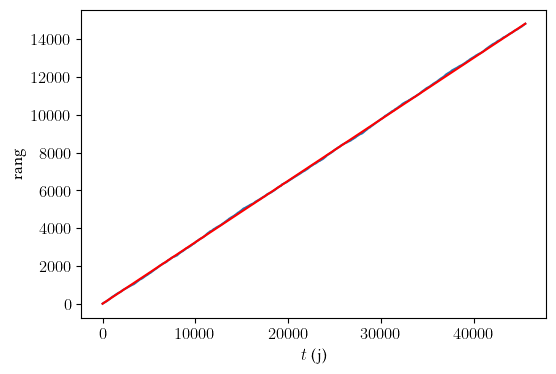

In [7]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(temps_cumulé, range(len(temps_cumulé)))
ax.plot([0,durée_totale],[0,nb_evt],color='red')
ax.set_xlabel(r'$t$ (j)')
ax.set_ylabel(r'rang')

## Depuis 2020

En moyenne, il y a 115.7 précipitations par an à Lausanne depuis le 1ier janvier 2020.


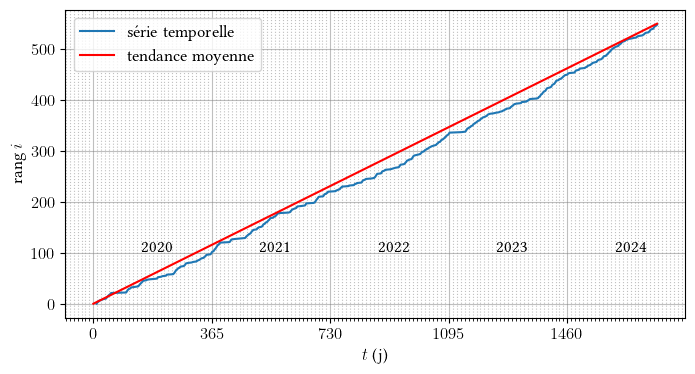

In [8]:
# sélection des précipitations à partir du 1er janvier 2020
précipitations_2020 = data[data.date.dt.year>=2020]

pluies_2020 = précipitations_2020[précipitations_2020['precip']>1]
dates_2020  = pluies_2020.date
délai_2020  = np.diff(dates_2020)/ np.timedelta64(1, 'D')
temps_cumulé_2020 = np.cumsum(délai_2020)
durée_totale_2020 = temps_cumulé_2020[-1]
# On définit le nombre d'événements
nb_evt_2020 = len(pluies_2020)
# on définit la durée totale de la série temporelle
# taux annuel des précipitations
print(f"En moyenne, il y a {nb_evt_2020/durée_totale_2020*365.25:0.1f} précipitations par an à Lausanne depuis le 1ier janvier 2020.")

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(temps_cumulé_2020, range(len(temps_cumulé_2020)),label='série temporelle')
ax.plot([0,durée_totale_2020],[0,nb_evt_2020],color='red',label='tendance moyenne')
ax.legend(loc='upper left',frameon=True)
ax.set_xlabel(r'$t$ (j)')
ax.set_ylabel(r'rang $i$')

# marques tous les 365 j.
ax.xaxis.set_major_locator(MultipleLocator(365))
 

# Grille
ax.xaxis.set_minor_locator(AutoMinorLocator(30))
ax.grid(which='major', color='grey', linestyle='-', alpha=0.5)
ax.grid(which='minor', color='grey', linestyle=':', alpha=0.5)
années = [i for i in range(2020,2025)]
for i in range(0,5):
    ax.text((i+0.4)*365 ,100,années[i])

Text(0.1, 0.95, '(b)')

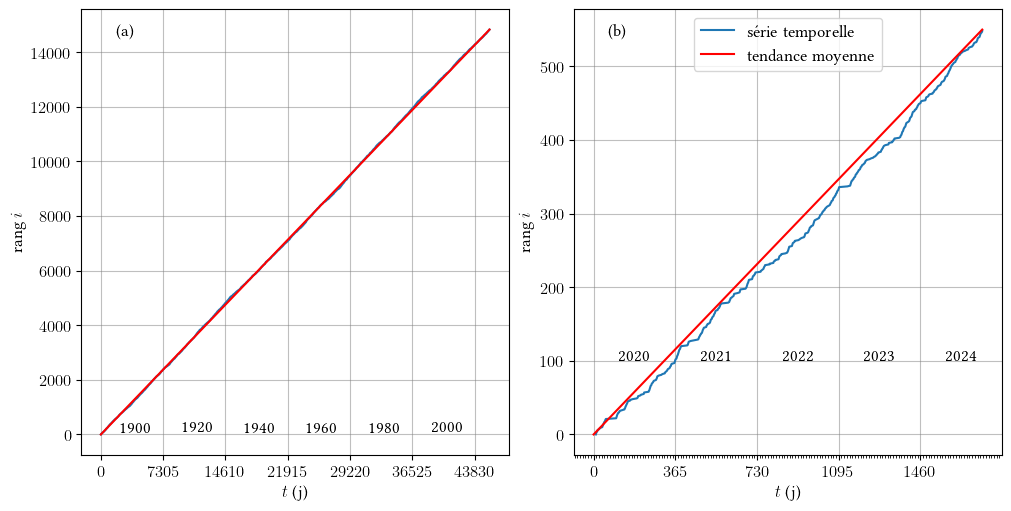

In [70]:
fig, ((ax1, ax2) ) = plt.subplots(1, 2, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(5*2)

ax1.plot(temps_cumulé, range(len(temps_cumulé)))
ax1.plot([0,durée_totale],[0,nb_evt],color='red')
ax1.set_xlabel(r'$t$ (j)')
ax1.set_ylabel(r'rang $i$')
# marque
ax1.xaxis.set_major_locator(MultipleLocator(365.25*20))
 
# grille
ax1.grid(which='major', color='grey', linestyle='-', alpha=0.5)
années = [i for i in range(1900,2024,20)]

for i in range(0,6):
    ax1.text((i +0.3)*365.25*20,100,années[i])

# Années > 2019
ax2.plot(temps_cumulé_2020, range(len(temps_cumulé_2020)),label='série temporelle')
ax2.plot([0,durée_totale_2020],[0,nb_evt_2020],color='red',label='tendance moyenne')
ax2.legend(loc='upper center',frameon=True)
ax2.set_xlabel(r'$t$ (j)')
ax2.set_ylabel(r'rang $i$')

# marque
ax2.xaxis.set_major_locator(MultipleLocator(365))
 
# grille
ax2.xaxis.set_minor_locator(AutoMinorLocator(30))
ax2.grid(which='major', color='grey', linestyle='-', alpha=0.5)
années = [i for i in range(2020,2025)]
for i in range(0,5):
    ax2.text((i+0.3)*365 ,100,années[i])

ax1.text(0.1,0.95,'(a)', horizontalalignment='center',
     verticalalignment='center',
     transform = ax1.transAxes)
ax2.text(0.1,0.95,'(b)', horizontalalignment='center',
     verticalalignment='center',
     transform = ax2.transAxes)

In [71]:
fig.savefig('test_stationnarité.png',dpi=300,bbox_inches='tight')

# Nombre annuel d'événements

In [40]:
# On considère les précipitations dont l'intensité dépasse un seuil
seuil = 1
pluies_seuil = pluies[pluies.precip>seuil]
nb_annuel_pluies = np.array(pluies_seuil.groupby(by=[ data.date.dt.year  ])['precip'].count())

In [41]:
# On ne garde pas la dernière année puisque 2024 est incomplète
nb_annuel_pluies = nb_annuel_pluies[:-1]
nb_annuel_pluies

array([112, 125, 141, 115, 104, 126,  97, 109,  89, 122, 140, 104, 121,
       122, 123, 136, 137, 113, 104, 140, 102,  80, 153, 122, 114, 113,
       123, 143, 127, 115, 151, 125, 119, 107, 104, 129, 128, 134, 113,
       136, 125, 125,  96, 105, 114, 108, 106, 111, 124,  94, 121, 133,
       140,  83, 117, 116, 113, 104, 124, 109, 128, 123, 109, 112, 104,
       155, 127, 118, 138, 114, 126,  89,  95, 106, 132, 113,  94, 147,
       131, 137, 129, 141, 122, 120, 129, 107, 133, 127, 138,  91, 115,
       106, 119, 127, 132, 127, 118, 123, 118, 137, 128, 141, 125,  94,
       108,  96, 111, 123, 131, 111, 114,  97, 134, 133, 127,  93, 123,
       119, 108, 118,  98, 119, 109, 120])

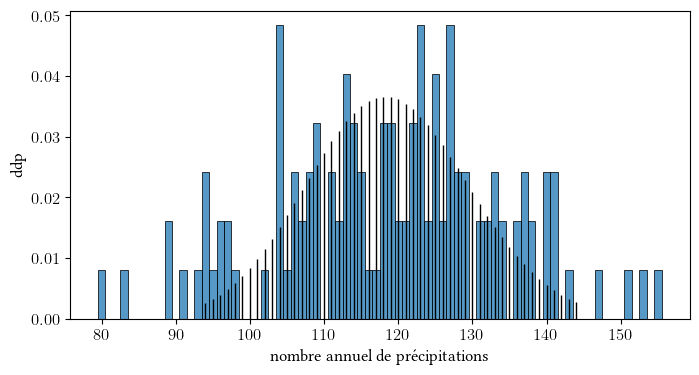

In [42]:
import seaborn as sns
from scipy.stats import poisson, nbinom, expon

 
fig, ax = plt.subplots(figsize=(8,4))
 
# histogramme
sns.histplot(nb_annuel_pluies, ax = ax,  stat = "density", discrete = True )
 
plt.xlabel('nombre annuel de précipitations')
plt.ylabel('ddp')

# pdf théorique de la loi de Poisson calée sur les données
nb_moyen = np.mean(nb_annuel_pluies)
distribution_calée = poisson(nb_moyen)
x = np.arange(poisson.ppf(0.01, nb_moyen),poisson.ppf(0.99, nb_moyen))
ax.vlines(x, 0, distribution_calée.pmf(x), colors='k', linestyles='-', lw=1, label='loi de Poisson')

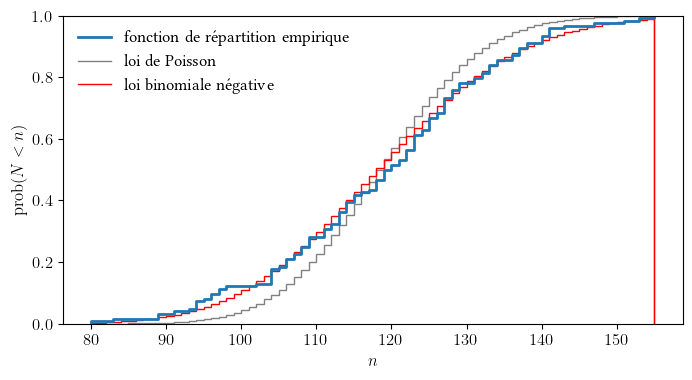

In [44]:
# On trace la fonction de répartition empirique
fig, ax = plt.subplots(figsize=(8,4))

ax.ecdf(nb_annuel_pluies, linewidth = 2, label="fonction de répartition empirique")


# loi de Poisson
x = np.arange(min(nb_annuel_pluies),max(nb_annuel_pluies))
y = poisson.cdf(x, nb_moyen)
ax.stairs(y,  np.append(x,x[-1]+1),color='grey',label = 'loi de Poisson')

# loi binomiale négative
moy = np.mean(nb_annuel_pluies)
var = np.var(nb_annuel_pluies)
p = moy/var
q = moy**2/(var-moy)

y = nbinom.cdf(x,q,p)
ax.stairs(y,  np.append(x,x[-1]+1),color = 'red',label = 'loi binomiale négative')
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$\mathrm{prob}(N< n)$")
ax.legend(loc='upper left',frameon=False)

Text(0.9, 0.1, '(b)')

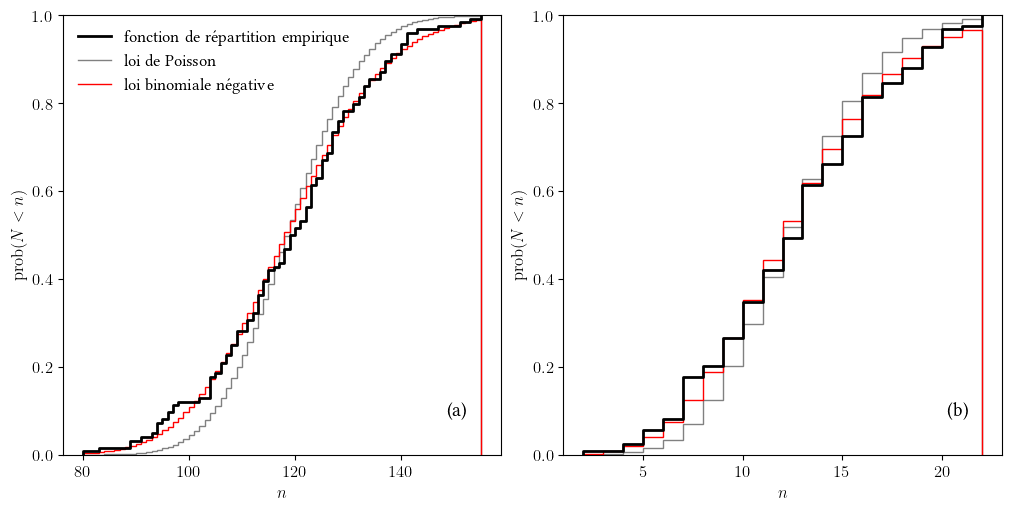

In [54]:
fig, ((ax1, ax2) ) = plt.subplots(1, 2, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(5*2)
# On considère les précipitations dont l'intensité dépasse un seuil
seuil = 1
pluies_seuil     = pluies[pluies.precip>seuil]
nb_annuel_pluies = np.array(pluies_seuil.groupby(by=[ data.date.dt.year  ])['precip'].count())
# On ne garde pas la dernière année puisque 2024 est incomplète
nb_annuel_pluies = nb_annuel_pluies[:-1]
nb_moyen = np.mean(nb_annuel_pluies)
ax1.ecdf(nb_annuel_pluies, color='black', linewidth = 2, label="fonction de répartition empirique")
# loi de Poisson
x = np.arange(min(nb_annuel_pluies),max(nb_annuel_pluies))
y = poisson.cdf(x, nb_moyen)
ax1.stairs(y,  np.append(x,x[-1]+1),color='grey',label = 'loi de Poisson')

# loi binomiale négative
moy = np.mean(nb_annuel_pluies)
var = np.var(nb_annuel_pluies)
p = moy/var
q = moy**2/(var-moy)
y = nbinom.cdf(x,q,p)
ax1.stairs(y,  np.append(x,x[-1]+1),color = 'red',label = 'loi binomiale négative')
ax1.set_xlabel(r"$n$")
ax1.set_ylabel(r"$\mathrm{prob}(N< n)$")
ax1.legend(loc='upper left',frameon=False)

# seuil 20 mm
seuil = 20
pluies_seuil     = pluies[pluies.precip>seuil]
nb_annuel_pluies = np.array(pluies_seuil.groupby(by=[ data.date.dt.year  ])['precip'].count())
# On ne garde pas la dernière année puisque 2024 est incomplète
nb_annuel_pluies = nb_annuel_pluies[:-1]
nb_moyen = np.mean(nb_annuel_pluies)
ax2.ecdf(nb_annuel_pluies, linewidth = 2, color='black',label="fnc. de répartition empirique")
# loi de Poisson
x = np.arange(min(nb_annuel_pluies),max(nb_annuel_pluies))
y = poisson.cdf(x, nb_moyen)
ax2.stairs(y,  np.append(x,x[-1]+1),color='grey',label = 'loi de Poisson')

# loi binomiale négative
moy = np.mean(nb_annuel_pluies)
var = np.var(nb_annuel_pluies)
p = moy/var
q = moy**2/(var-moy)

y = nbinom.cdf(x,q,p)
ax2.stairs(y,  np.append(x,x[-1]+1),color = 'red',label = 'loi binomiale négative')
ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"$\mathrm{prob}(N< n)$")
 

ax1.text(0.9,0.1,'(a)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax1.transAxes)
ax2.text(0.9,0.1,'(b)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax2.transAxes)

In [56]:
fig.savefig('test_nombre.png',dpi=300,bbox_inches='tight')

# Loi de distribution de l'intensité des précipitations

In [57]:
seuil = 0.1
pluies_seuil = pluies[pluies.precip>=seuil]

valeurs_journalières_triées = np.sort(np.array(pluies_seuil.precip) )[::-1]
nb_valeurs = len(valeurs_journalières_triées)
fréquences_empiriques = [i/(1+nb_valeurs) for i in range(nb_valeurs)]

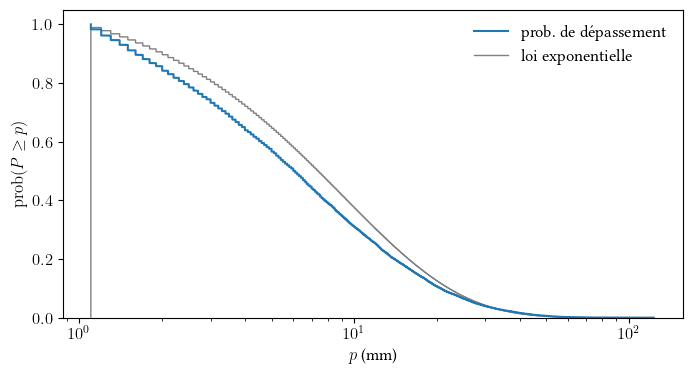

In [58]:
# On trace la fonction de répartition empirique
fig, ax = plt.subplots(figsize=(8,4))
ax.semilogx(valeurs_journalières_triées,fréquences_empiriques,label='prob. de dépassement')
ax.set_xlabel(r"$p$ (mm)")
ax.set_ylabel(r"$\mathrm{prob}(P\geq p)$")


# loi de exponentielle
x = np.arange(min(valeurs_journalières_triées),max(valeurs_journalières_triées),.1)
pluie_journalière_moyenne = np.mean(valeurs_journalières_triées)
y = 1- expon.cdf(x, scale=pluie_journalière_moyenne, loc=1)
ax.stairs(y,  np.append(x,x[-1]+1),color='grey',label = 'loi exponentielle')
ax.legend(loc='upper right',frameon=False)

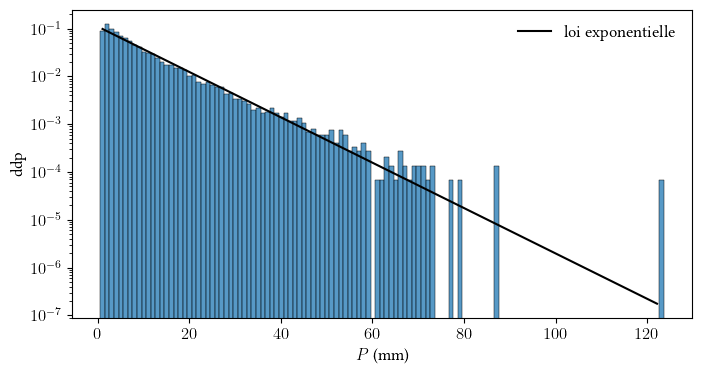

In [86]:
fig, ax = plt.subplots(figsize=(8,4))
 
# histogramme
sns.histplot(valeurs_journalières_triées, ax = ax,  stat = "density", log=True , discrete = True)
 
plt.xlabel(r'$P$ (mm)')
plt.ylabel('ddp')

# pdf théorique de la loi de Poisson calée sur les données
x = np.arange(np.min(valeurs_journalières_triées),np.max(valeurs_journalières_triées))
ax.plot(x,   expon.pdf(x, scale=pluie_journalière_moyenne, loc=0.1), color='k',  label='loi exponentielle')
ax.legend(loc='upper right',frameon=False)


Text(0.9, 0.8, '(b)')

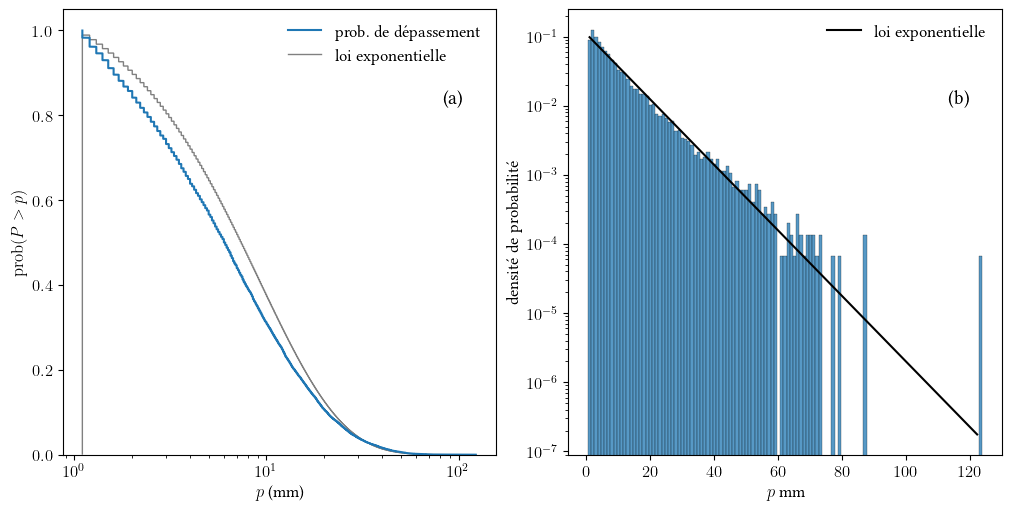

In [66]:
seuil = 0.1
pluies_seuil = pluies[pluies.precip>=seuil]

valeurs_journalières_triées = np.sort(np.array(pluies_seuil.precip) )[::-1]
nb_valeurs = len(valeurs_journalières_triées)
fréquences_empiriques = [i/(1+nb_valeurs) for i in range(nb_valeurs)]


fig, ((ax1, ax2) ) = plt.subplots(1, 2, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(5*2)

# On trace la fonction de répartition empirique
ax1.semilogx(valeurs_journalières_triées,fréquences_empiriques,label='prob. de dépassement')
ax1.set_xlabel(r"$p$ (mm)")
ax1.set_ylabel(r"$\mathrm{prob}(P> p)$")


# loi de exponentielle
x = np.arange(min(valeurs_journalières_triées),max(valeurs_journalières_triées),.1)
pluie_journalière_moyenne = np.mean(valeurs_journalières_triées)
y = 1- expon.cdf(x, scale=pluie_journalière_moyenne, loc=1)
ax1.stairs(y,  np.append(x,x[-1]+1),color='grey',label = 'loi exponentielle')
ax1.legend(loc='upper right',frameon=False)

# histogramme
sns.histplot(valeurs_journalières_triées, ax = ax2,  stat = "density", log=True , discrete = True)
 
ax2.set(xlabel=r'$p$ mm', ylabel='densité de probabilité')
# pdf théorique de la loi de Poisson calée sur les données
x = np.arange(np.min(valeurs_journalières_triées),np.max(valeurs_journalières_triées))
ax2.plot(x,   expon.pdf(x, scale=pluie_journalière_moyenne, loc=0.1), color='k',  label='loi exponentielle')
ax2.legend(loc='upper right',frameon=False)

ax1.text(0.9,0.8,'(a)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax1.transAxes)
ax2.text(0.9,0.8,'(b)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax2.transAxes)

In [67]:
fig.savefig('test_densité.png',dpi=300,bbox_inches='tight')

In [72]:
pluie_journalière_moyenne

9.14369056451069

## Comparaison entre périodes

In [83]:
 # on sélectionne les pluies suffisamment significatives P > 1 mm
pluies = data[data['precip']>=1]

pluies_1940 = pluies[pluies.date.dt.year<1940]
valeurs_1940 = np.sort(np.array(pluies_1940.precip) )[::-1]
nb_valeurs_1940 = len(valeurs_1940)
fréquences_1940= [i/(1+nb_valeurs_1940) for i in range(nb_valeurs_1940)]

pluies_1980 = pluies[(pluies.date.dt.year>=1940) & (pluies.date.dt.year<1980)]
valeurs_1980 = np.sort(np.array(pluies_1980.precip) )[::-1]
nb_valeurs_1980 = len(valeurs_1980)
fréquences_1980= [i/(1+nb_valeurs_1980) for i in range(nb_valeurs_1980)]

pluies_2020 = pluies[(pluies.date.dt.year>=1980) & (pluies.date.dt.year<2020)]
valeurs_2020 = np.sort(np.array(pluies_2020.precip) )[::-1]
nb_valeurs_2020 = len(valeurs_2020)
fréquences_2020= [i/(1+nb_valeurs_2020) for i in range(nb_valeurs_2020)]

pluies_actuelles = pluies[ pluies.date.dt.year>=2020]
valeurs_actuelles = np.sort(np.array(pluies_actuelles.precip) )[::-1]
nb_valeurs_actuelles = len(valeurs_actuelles)
fréquences_actuelles= [i/(1+nb_valeurs_actuelles) for i in range(nb_valeurs_actuelles)]

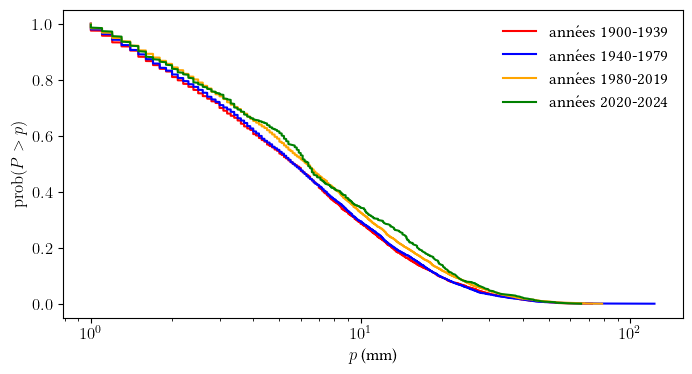

In [84]:
# On trace la fonction de répartition empirique
fig, ax = plt.subplots(figsize=(8,4))
ax.semilogx(valeurs_1940,fréquences_1940,label='années 1900-1939',color='red')
ax.semilogx(valeurs_1980,fréquences_1980,label='années 1940-1979',color='blue')
ax.semilogx(valeurs_2020,fréquences_2020,label='années 1980-2019',color='orange')
ax.semilogx(valeurs_actuelles,fréquences_actuelles,label='années 2020-2024',color='green')
ax.set_xlabel(r"$p$ (mm)")
ax.set_ylabel(r"$\mathrm{prob}(P> p)$")
ax.legend(loc='upper right',frameon=False)
 


Text(0.1, 0.1, '(b)')

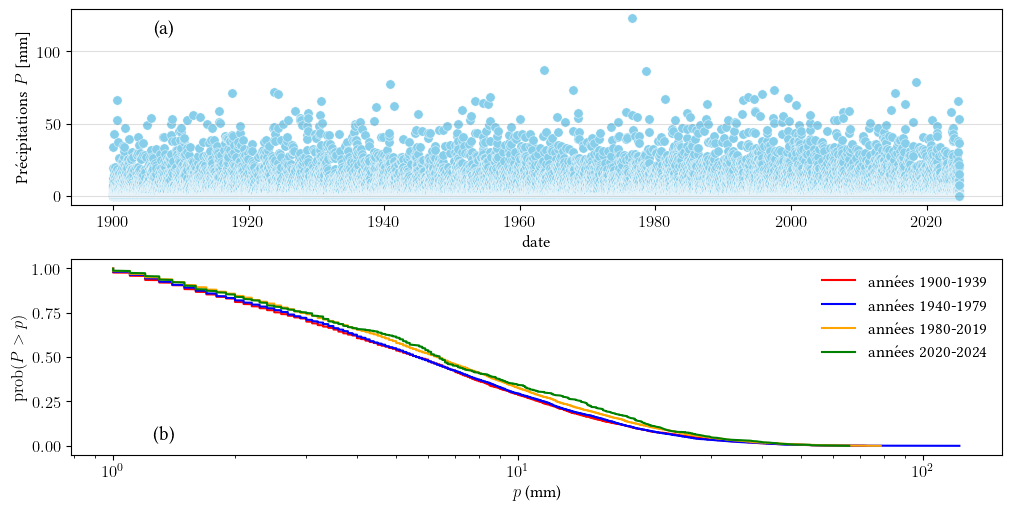

In [90]:
 # distribution temporelle des distributions

fig, ((ax1, ax2) ) = plt.subplots(2, 1, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(5*2)
ax1.scatter(data['date'], data["precip"] ,  marker = "o",edgecolors='white',linewidths=0.3, s=45, color='skyblue', alpha = 1)
ax1.set_ylabel(r'Précipitations $P$  [mm] ')
ax1.set_xlabel(r'date')
ax1.grid(axis="y", color = 'gray', alpha = 0.25)

ax2.semilogx(valeurs_1940,fréquences_1940,label='années 1900-1939',color='red')
ax2.semilogx(valeurs_1980,fréquences_1980,label='années 1940-1979',color='blue')
ax2.semilogx(valeurs_2020,fréquences_2020,label='années 1980-2019',color='orange')
ax2.semilogx(valeurs_actuelles,fréquences_actuelles,label='années 2020-2024',color='green')
ax2.set_xlabel(r"$p$ (mm)")
ax2.set_ylabel(r"$\mathrm{prob}(P> p)$")
ax2.legend(loc='upper right',frameon=False)

ax1.text(0.1,0.9,'(a)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax1.transAxes)
ax2.text(0.1,0.1,'(b)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax2.transAxes)

In [91]:
fig.savefig('test_répartition.png',dpi=300,bbox_inches='tight')

In [8]:
data.groupby(by=data.date.dt.year)['precip'].sum()

date
1900     956.0
1901    1047.4
1902    1088.1
1903     952.0
1904     788.0
         ...  
2020    1125.4
2021    1294.4
2022     940.0
2023    1246.5
2024    1045.6
Name: precip, Length: 125, dtype: float64

# Corrélation

In [9]:
# import des fonctions utiles
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Autocorrélation et autocorrélation partielle

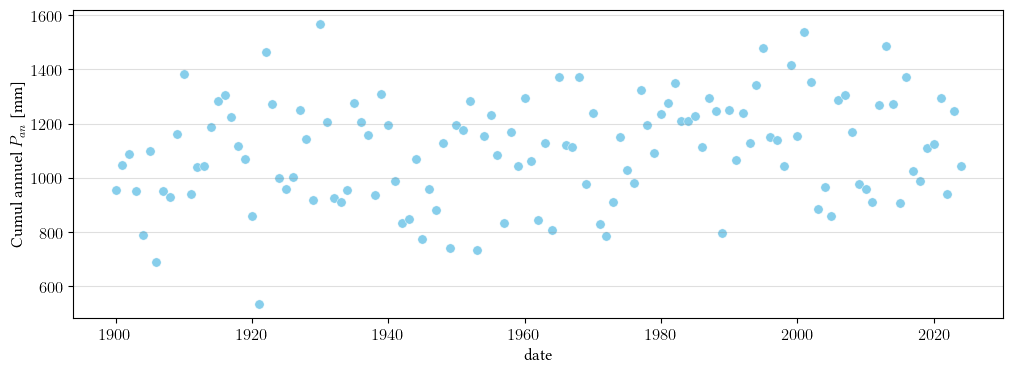

In [39]:
# calcul du cumul annuel
cumul_annuel = data.groupby(by=data.date.dt.year)['precip'].sum()

 # distribution temporelle des cumuls annuels de précipitations
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(cumul_annuel.index, cumul_annuel.values,  marker = "o",edgecolors='white',linewidths=0.3, s=45, color='skyblue', alpha = 1)
ax.set_ylabel(r'Cumul annuel $P_{an}$  [mm] ')
ax.set_xlabel(r'date')
plt.grid(axis="y", color = 'gray', alpha = 0.25)



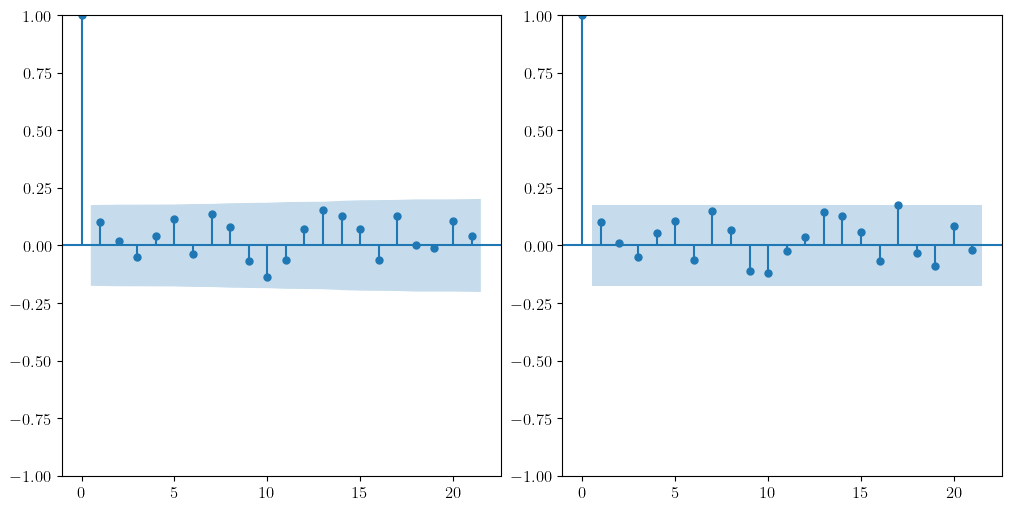

In [84]:
# Tracé de l'autocorrélation et de l'autocorrélation partielle
fig, ((ax1, ax2) ) = plt.subplots(1, 2, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(5*2)
plot_acf(cumul_annuel,ax=ax1,title=None);
plot_pacf(cumul_annuel,ax=ax2,title=None);

### Synthèse

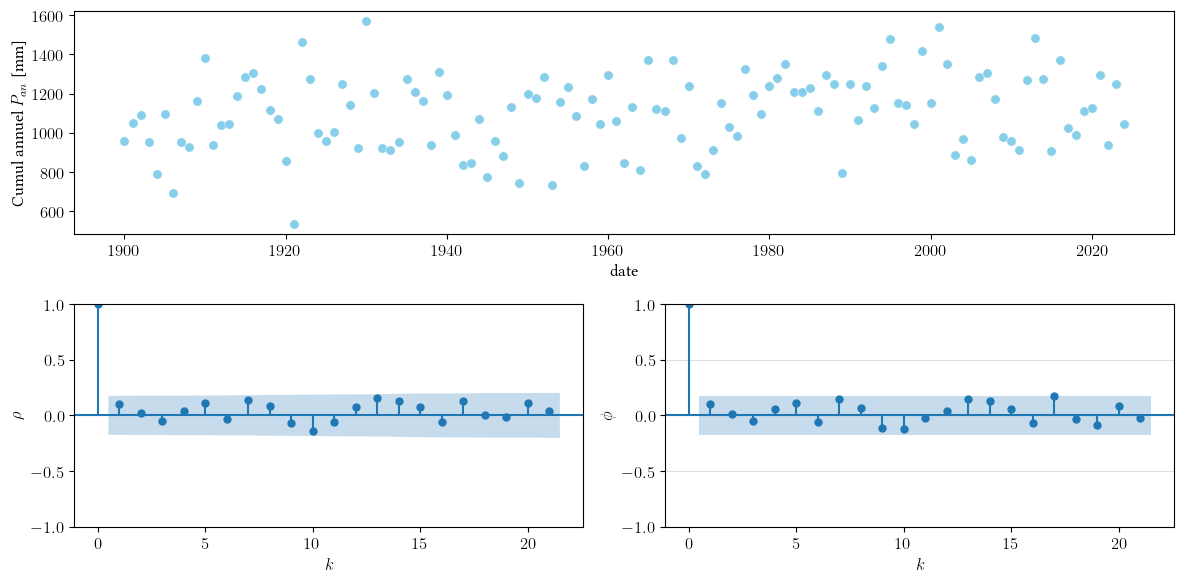

In [87]:
fig = plt.figure(figsize=(12,6))

ax1=plt.subplot(2, 1, 1)
ax2=plt.subplot(2, 2, 3) 
ax3=plt.subplot(2, 2, 4)

ax1.scatter(cumul_annuel.index, cumul_annuel.values,  marker = "o",edgecolors='white',linewidths=0.3, s=45, color='skyblue', alpha = 1)
ax1.set_ylabel(r'Cumul annuel $P_{an}$  [mm] ')
ax1.set_xlabel(r'date')
plt.grid(axis="y", color = 'gray', alpha = 0.25)

plot_acf(cumul_annuel,ax=ax2,title=None);
plot_pacf(cumul_annuel,ax=ax3,title=None);
ax2.set_ylabel(r'$\rho$ ')
ax2.set_xlabel(r'$k$')
ax3.set_ylabel(r'$\phi$ ')
ax3.set_xlabel(r'$k$')
plt.tight_layout()

In [88]:
# export
fig.savefig('lausanne_acf_pacf.png',dpi=300,bbox_inches='tight')

### Filtrage

In [89]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Parameters
    ----------
    window : int
        The length of the filter window.
    cutoff : float
        The cutoff frequency in inverse time steps.

    """
    order = ((window - 1) // 2) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1.0, n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2.0 * np.pi * cutoff * k) / (np.pi * k)
    w[n - 1 : 0 : -1] = firstfactor * sigma
    w[n + 1 : -1] = firstfactor * sigma
    return w[1:-1]

In [59]:
# création d'un xarray pour faire des moyennes mobiles
import xarray as xr
série_poste_annuelle = pd.Series(cumul_annuel.values, index =  cumul_annuel.index,name='precip')
série_poste_annuelle.index.name = 'time'
da = série_poste_annuelle.to_xarray()

In [90]:
# Window length for filters.
window = 20
wgts = low_pass_weights(window, 1.0 /6)
weight_low = xr.DataArray(wgts, dims = ['precip'])
daf = da.rolling(time = len(wgts), center = True).construct('precip').dot(weight_low)

Text(0, 0.5, 'cumul annuel')

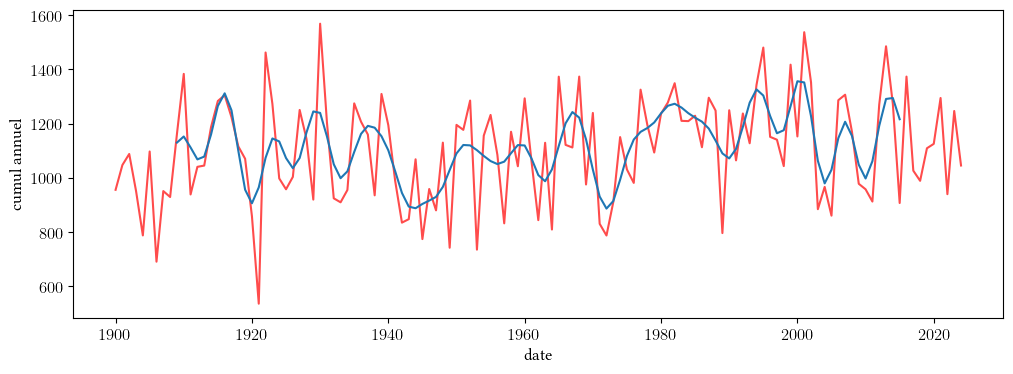

In [92]:
fig, axs = plt.subplots(figsize=(12, 4))
axs.plot(série_poste_annuelle.index, série_poste_annuelle, color='red', alpha = 0.7, linewidth = 1.5, 
         label = "cumul annuel" )

daf.plot(ax=axs)
 

axs.set_xlabel(r"date  ")
axs.set_ylabel(r'cumul annuel')

In [93]:
# Window length for filters.
    # construct 3 days and 10 days low pass filters
window = 20
hfw = low_pass_weights(window, 1. / 7.)
lfw = low_pass_weights(window, 1. / 17.)
weight_high = xr.DataArray(hfw, dims = ['window'])
weight_low = xr.DataArray(lfw, dims = ['window'])

lowpass_hf = da.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
lowpass_lf = da.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)
bandpass = série_poste_annuelle.mean()+lowpass_hf - lowpass_lf

couleur = 'red'

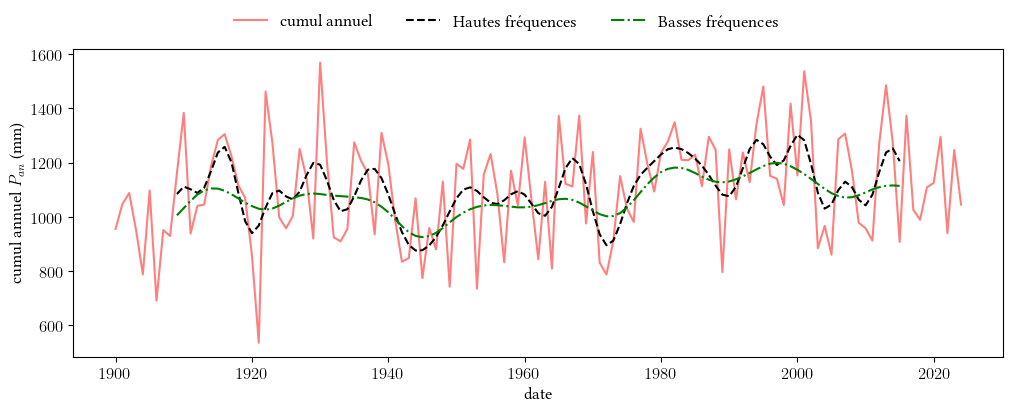

In [94]:
fig, axs = plt.subplots(figsize=(12, 4))
axs.plot(série_poste_annuelle.index, série_poste_annuelle, color=couleur, alpha = 0.5, linewidth = 1.5, 
         label = "cumul annuel" )


lowpass_hf.plot.line(ax=axs,color='black',linestyle="--",label = "Hautes fréquences" )
lowpass_lf.plot.line(ax=axs,color='green',linestyle="-.",label = "Basses fréquences" )
#bandpass.plot(ax=axs,label = "passe bande" )
 

axs.set_xlabel(r"date  ")
axs.set_ylabel(r'cumul annuel $P_{an}$ (mm)')
fig.legend(loc="upper center",ncol=3,frameon=False)

In [95]:
# export
fig.savefig('lausanne_cycles.png',dpi=300,bbox_inches='tight')

### ARMA

In [109]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
# Calage de AR(1)  
modèle_AR = ARIMA(cumul_annuel.values, order=(1, 0,0))
résultat = modèle_AR.fit()

# résultat
print(résultat.summary())



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  125
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -834.629
Date:                Thu, 07 Nov 2024   AIC                           1675.257
Time:                        21:44:39   BIC                           1683.742
Sample:                             0   HQIC                          1678.704
                                - 125                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1101.9984     19.611     56.193      0.000    1063.562    1140.435
ar.L1          0.1010      0.088      1.152      0.249      -0.071       0.273
sigma2      3.703e+04   5040.916      7.346      0.0

In [110]:
# Résultats sous forme condensée
 
print(résultat.params)

[1.10199839e+03 1.01007481e-01 3.70320871e+04]


In [112]:
modèle_AR.__dict__


{'_spec_arima': SARIMAXSpecification(endog=y, exog=['const'], order=(1, 0, 0), concentrate_scale=False),
 '_spec': SARIMAXSpecification(endog=y, exog=['const'], order=(1, 0, 0), concentrate_scale=False),
 '_params': SARIMAXParams(exog=[nan], ar=[-1.], sigma2=nan),
 'order': (1, 0, 0),
 'seasonal_order': (0, 0, 0, 0),
 'seasonal_periods': 0,
 'measurement_error': False,
 'time_varying_regression': False,
 'mle_regression': True,
 'simple_differencing': False,
 'enforce_stationarity': True,
 'enforce_invertibility': True,
 'hamilton_representation': False,
 'concentrate_scale': False,
 'use_exact_diffuse': False,
 'polynomial_ar': array([1., 1.]),
 '_polynomial_ar': array([ 1.        , -0.10100748]),
 'polynomial_ma': array([1.]),
 '_polynomial_ma': array([1.]),
 'polynomial_seasonal_ar': array([1.]),
 '_polynomial_seasonal_ar': array([1.]),
 'polynomial_seasonal_ma': array([1.]),
 '_polynomial_seasonal_ma': array([1.]),
 'trend': 'c',
 'trend_offset': 1,
 'polynomial_trend': array([], d

In [111]:
sm.stats.durbin_watson(modèle_AR.resid.values)


AttributeError: 'ARIMA' object has no attribute 'resid'

## Cumuls mensuels

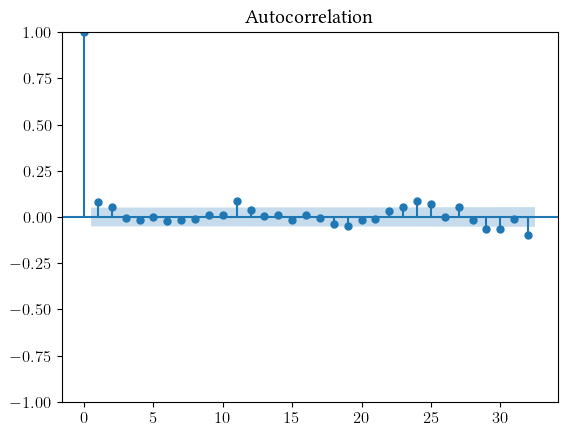

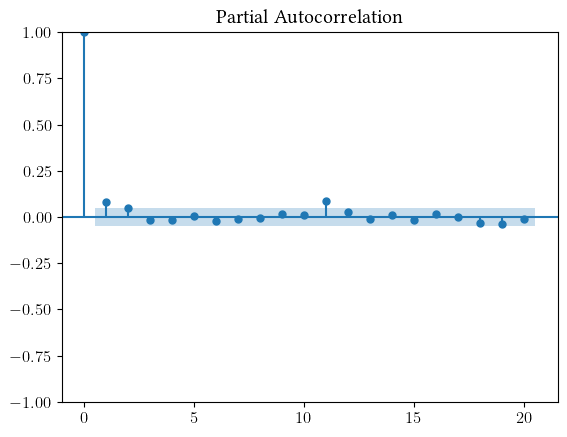

In [86]:
cumul_mensuel = data.groupby(by=[data.date.dt.year,data.date.dt.month])['precip'].sum()
plot_acf(cumul_mensuel);
plot_pacf(np.array(cumul_mensuel.values),lags=20, method="ywm");